Schema Evolution in Apache Iceberg (Brief Explanation)

Schema evolution in Iceberg means you can change the table schema safely, without rewriting existing data, and without breaking old queries. Iceberg maintains compatibility because every column has a unique ID internally — so renaming, reordering, or adding columns does not affect stored files.

In [ ]:
spark.stop()

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IcebergSparkWithMinIO") \
    .config("spark.sql.catalog.iceberg_catalog", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.iceberg_catalog.type", "rest") \
    .config("spark.sql.catalog.iceberg_catalog.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.iceberg_catalog.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.iceberg_catalog.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.iceberg_catalog.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.iceberg_catalog.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.iceberg_catalog.s3.secret-access-key", "password") \
    .config("spark.sql.catalog.iceberg_catalog.s3.path-style-access", "true") \
    .getOrCreate()

25/12/06 16:31:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## CREATE TABLE

In [3]:
spark.sql("""
    CREATE NAMESPACE IF NOT EXISTS iceberg_catalog.default
""")

DataFrame[]

In [2]:
spark.sql('''
CREATE TABLE iceberg_catalog.default.customer_orders (
    order_id BIGINT,
    customer_name STRING,
    order_date DATE
)
USING ICEBERG
''')

DataFrame[]

In [4]:
spark.sql('''
INSERT INTO iceberg_catalog.default.customer_orders 
VALUES 
    (1, 'Alice', DATE '2024-01-01'),
    (2, 'Bob', DATE '2024-01-02')
''')

DataFrame[]

In [5]:
spark.sql('''
SELECT * FROM iceberg_catalog.default.customer_orders
''').show()

+--------+-------------+----------+
|order_id|customer_name|order_date|
+--------+-------------+----------+
|       1|        Alice|2024-01-01|
|       2|          Bob|2024-01-02|
+--------+-------------+----------+



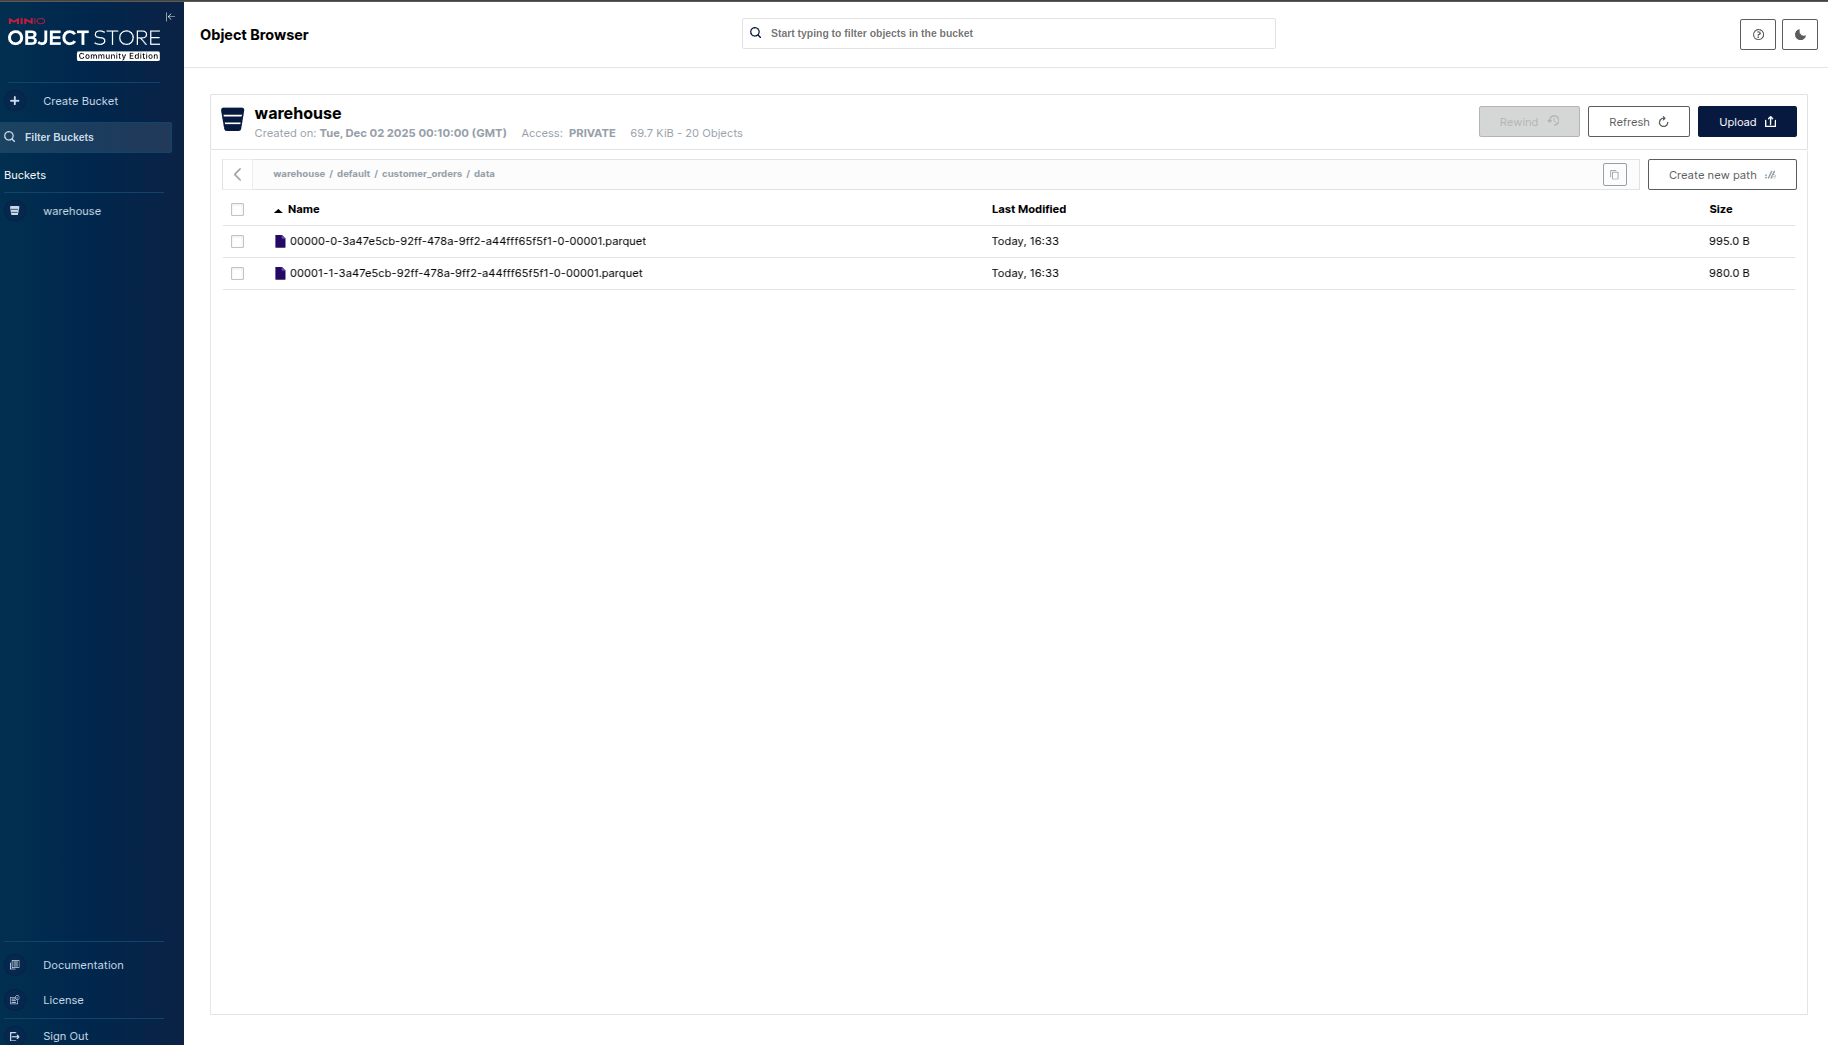

On minio we can see that we have just 2 parquet files as data files so let's now try to alter the table and see if this operattion affect the data files

## SCHEMA EVOLUTION 1 ADD NEW COLUMN

In [6]:
spark.sql('''
ALTER TABLE iceberg_catalog.default.customer_orders
ADD COLUMN total_amount DOUBLE
''')

DataFrame[]

In [7]:
spark.sql('''
SELECT * FROM iceberg_catalog.default.customer_orders
''').show()

+--------+-------------+----------+------------+
|order_id|customer_name|order_date|total_amount|
+--------+-------------+----------+------------+
|       1|        Alice|2024-01-01|        NULL|
|       2|          Bob|2024-01-02|        NULL|
+--------+-------------+----------+------------+



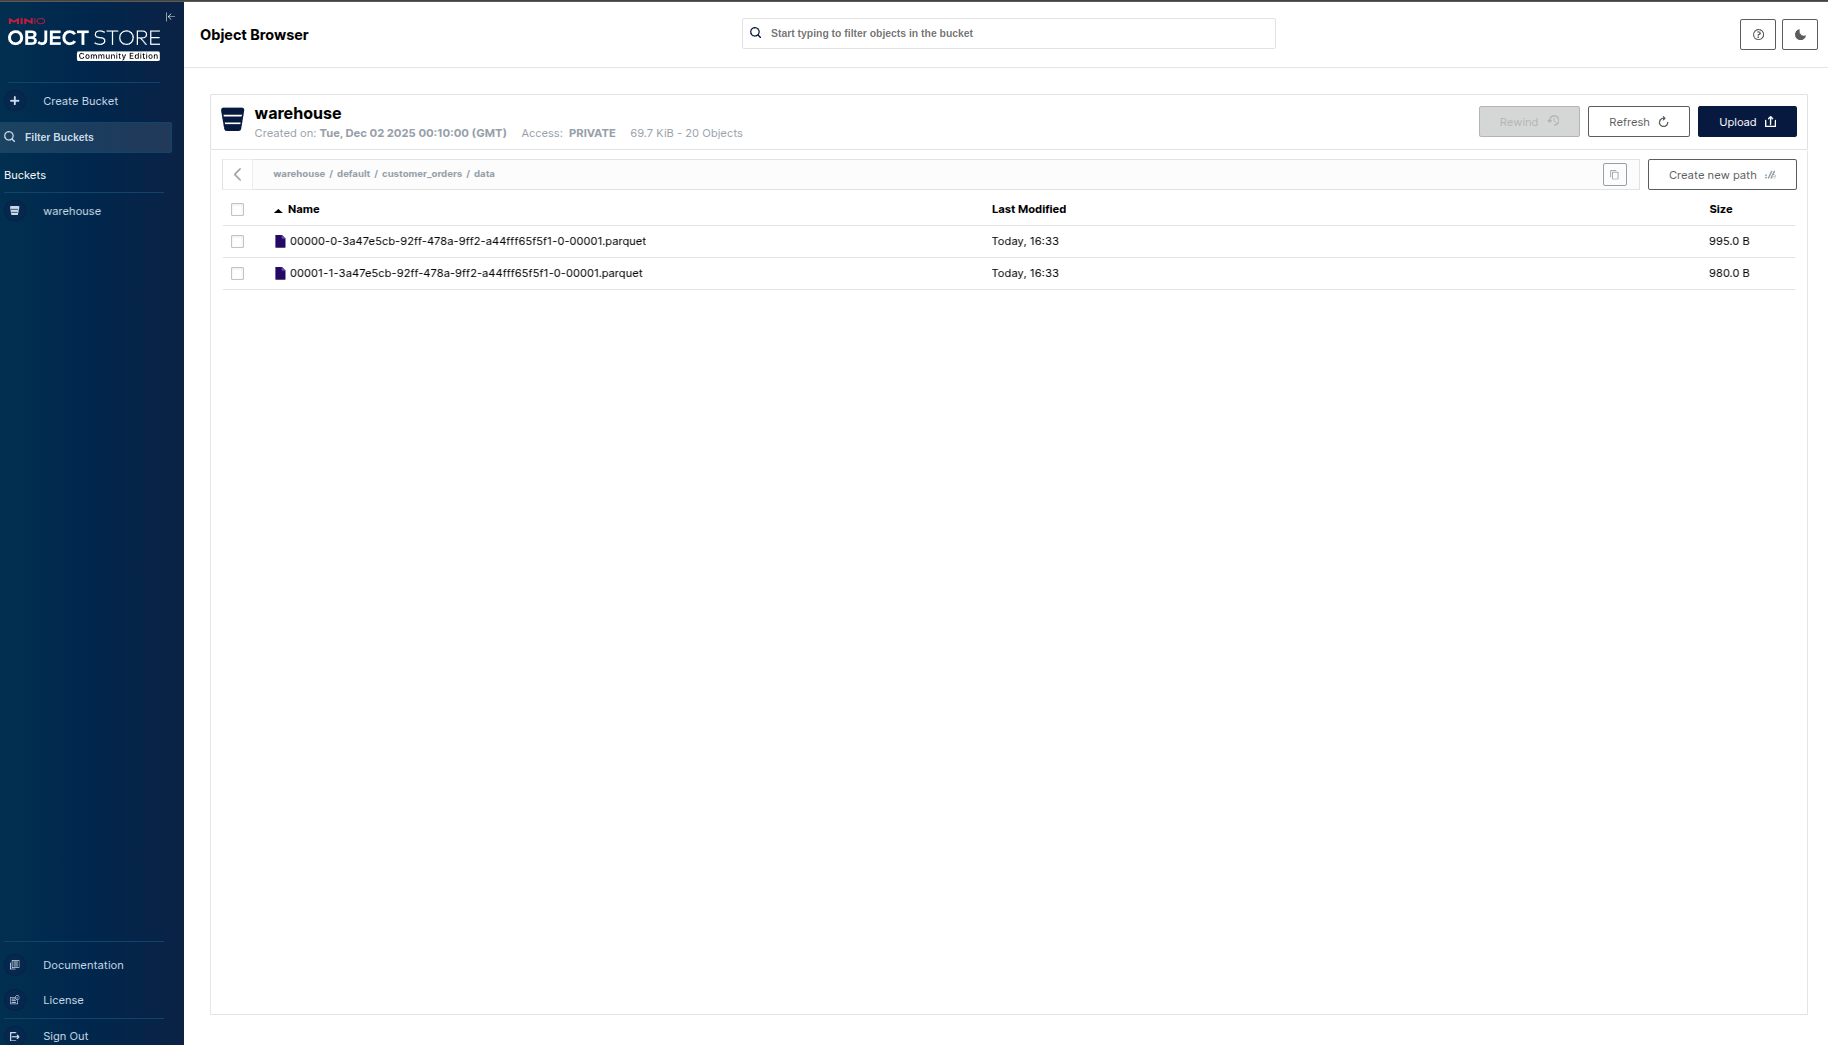
we still have our 2 files nothing has changed execpt the metadata

## INSERTION OF 2 NEW ROWS TO THIS CHANGED TABLE

In [8]:
spark.sql('''
INSERT INTO iceberg_catalog.default.customer_orders (order_id, customer_name, order_date, total_amount)
VALUES 
    (3, 'Charlie', DATE '2024-01-03', 150.75),
    (4, 'Diana', DATE '2024-01-04', 200.00)
''')

DataFrame[]

In [9]:
spark.sql('''
SELECT * FROM iceberg_catalog.default.customer_orders
''').show()

+--------+-------------+----------+------------+
|order_id|customer_name|order_date|total_amount|
+--------+-------------+----------+------------+
|       1|        Alice|2024-01-01|        NULL|
|       3|      Charlie|2024-01-03|      150.75|
|       4|        Diana|2024-01-04|       200.0|
|       2|          Bob|2024-01-02|        NULL|
+--------+-------------+----------+------------+



## SCHEMA EVOLUTION 2 DROP COLUMN

In [10]:
spark.sql('''
ALTER TABLE iceberg_catalog.default.customer_orders
DROP COLUMN customer_name
''')

DataFrame[]

In [11]:
spark.sql('''
SELECT * FROM iceberg_catalog.default.customer_orders
''').show()

+--------+----------+------------+
|order_id|order_date|total_amount|
+--------+----------+------------+
|       1|2024-01-01|        NULL|
|       3|2024-01-03|      150.75|
|       2|2024-01-02|        NULL|
|       4|2024-01-04|       200.0|
+--------+----------+------------+



## SCHEMA EVOLUTION 2 RENAME COLUMN

In [12]:
spark.sql('''
ALTER TABLE iceberg_catalog.default.customer_orders
RENAME COLUMN order_date TO purchase_date
''')

DataFrame[]

In [13]:
spark.sql('''
SELECT * FROM iceberg_catalog.default.customer_orders
''').show()

+--------+-------------+------------+
|order_id|purchase_date|total_amount|
+--------+-------------+------------+
|       1|   2024-01-01|        NULL|
|       3|   2024-01-03|      150.75|
|       2|   2024-01-02|        NULL|
|       4|   2024-01-04|       200.0|
+--------+-------------+------------+

